In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from typing_extensions import Self


class Value:
    def __init__(self, data: float, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other: Self | int):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other: Self | int):
        return self.__add__(other)

    def __mul__(self, other: Self | int):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other: Self | int):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)

    def __rmul__(self, other: Self | int):
        return self.__mul__(other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward

        return out

    def __truediv__(self, other: Self | int):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            # self.grad += other * (out.data**(other-1)) * out.grad
            # self.grad += (other * out.data / self.data) * out.grad
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        self.grad = 1.0
        topo: list[Value] = []
        visited = set()
        def build_topo(v: Value):
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build_topo(c)
                topo.append(v)

        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [3]:
a = Value(2.0)
b = Value(4.0)
c = a - b
c

Value(data=-2.0)

In [4]:
c.backward()
print(a.grad)  # 1.0
print(b.grad)  # -1.0

1.0
-1.0


In [5]:
from graphviz import Digraph

def trace(root):
    """Walks through a computation graph and returns a list of nodes in topological order.
    This is essentially a limited scope implementation of reverse-mode autodiff.
    """
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """Uses graphviz to draw a computation graph."""
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [6]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias b
b = Value(6.88137358, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()


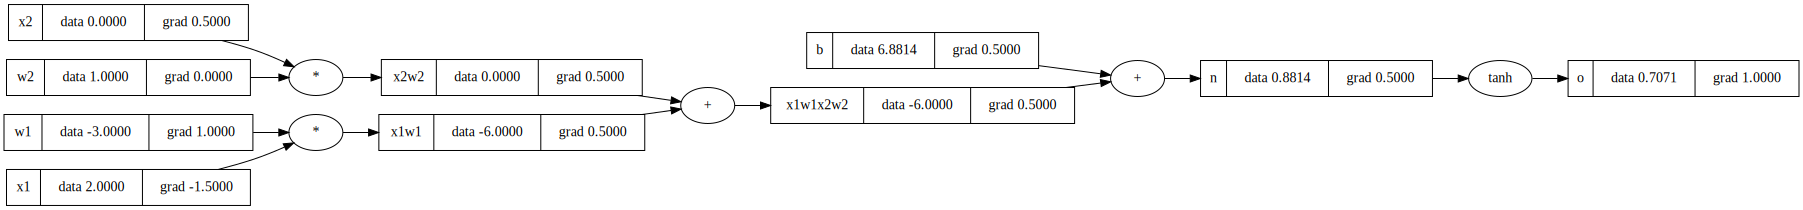

In [7]:
draw_dot(o)


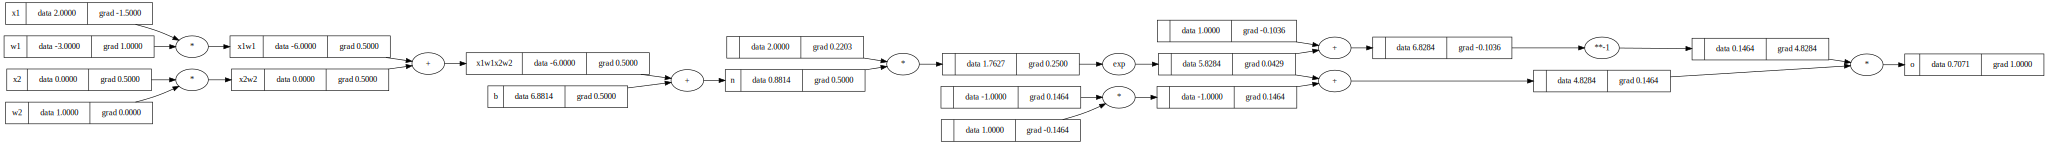

In [8]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias b
b = Value(6.88137358, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b
n.label = "n"
# ----
# o = n.tanh()
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = "o"
o.backward()
draw_dot(o)

In [14]:
import torch

x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.88137358]).double()
for val in [x1, x2, w1, w2, b]:
    val.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.data.item())
print("w2", w2.grad.data.item())
print("x1", x1.grad.data.item())
print("w1", w1.grad.data.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [44]:
import random
from typing import Any


class Neuron:
    def __init__(self, nin):
        # weights
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # bias
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


In [114]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8986233362654595)

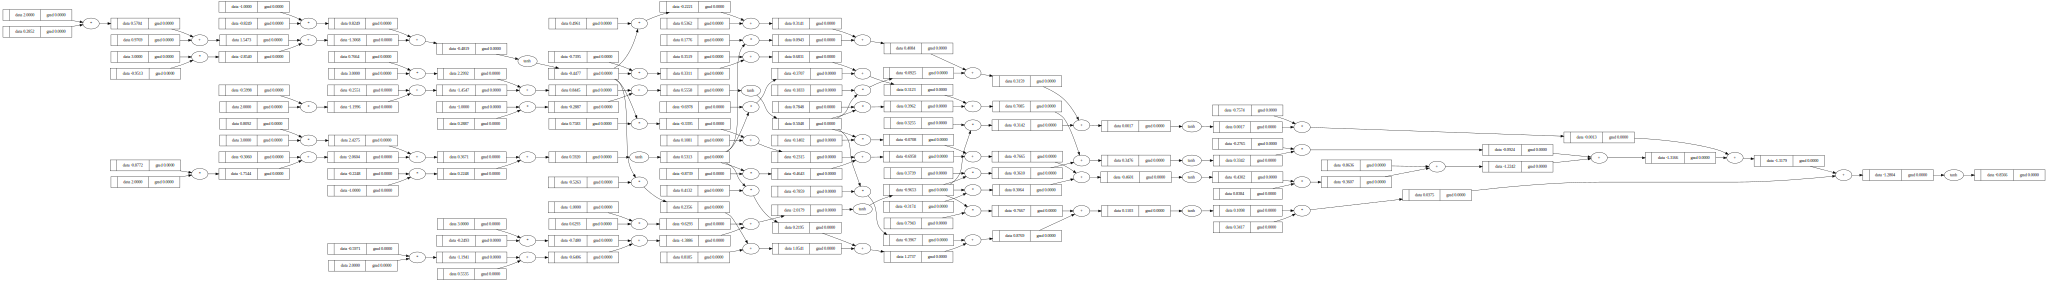

In [35]:
draw_dot(n(x))

In [115]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [136]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backprop
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data += - 0.1 * p.grad
    print(k, loss.data)

0 0.000976330978956503
1 0.0009717992166478152
2 0.0009673085498813191
3 0.0009628584269744432
4 0.0009584483060249135
5 0.0009540776546956651
6 0.0009497459500054889
7 0.0009454526781250791
8 0.0009411973341783794
9 0.0009369794220491303
10 0.0009327984541922935
11 0.0009286539514504573
12 0.0009245454428747703
13 0.00092047246555055
14 0.0009164345644272413
15 0.0009124312921527392
16 0.0009084622089117616
17 0.0009045268822683628
18 0.0009006248870123516
19 0.000896755805009456


In [137]:
ypred

[Value(data=0.98183182970283),
 Value(data=-0.9941037871355324),
 Value(data=-0.983218777737613),
 Value(data=0.9841791704926783)]